# Processing many large files

* Use `glob` to find file names
* Use a double loop to process all files in chunks
* We will show a more functional, lazy solution in a later section.

In [10]:
import pandas as pd
from dfply import *

## Example 3 - Compute the weekday totals for all months

Assume that we have many csv files, all with the same columns. Now we will step up the scale by processing many large files by

* Using `glob` to get all the filenames
* Prototyping our code on the first chunk of the first file
* Creating a list of aggregated chunks with a double loop
* Use the accumulator pattern to reduce the chunk aggregations to a single table.

In [2]:
!git clone https://github.com/fivethirtyeight/uber-tlc-foil-response.git ./data/uber

fatal: destination path './data/uber' already exists and is not an empty directory.


#### Get all files with `glob`

In [9]:
from glob import glob
files = glob('./data/uber/uber-trip-data/uber-raw-data-*.csv')
files = [f for f in files if 'jan' not in f]
files

['./data/uber/uber-trip-data/uber-raw-data-apr14.csv',
 './data/uber/uber-trip-data/uber-raw-data-aug14.csv',
 './data/uber/uber-trip-data/uber-raw-data-sep14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jul14.csv',
 './data/uber/uber-trip-data/uber-raw-data-jun14.csv',
 './data/uber/uber-trip-data/uber-raw-data-may14.csv']

#### Helper functions developed in an earlier section

In [16]:
from calendar import day_name
from functoolz import pipeable
weekday_categories = pd.CategoricalDtype(categories=list(day_name),
                                     ordered=True)
weekday_cnts = pipeable(lambda df: (df 
                                    >> mutate(weekday = X.date.dt.weekday_name.astype(weekday_categories)) 
                                    >> select(X.date, X.weekday))
                                    >> group_by(X.weekday) 
                                    >> summarise(cnt = n(X.weekday)))
        

In [17]:
c_size = 100000
new_names = ['date', 'lat', 'lon', 'base']
date_cols = ['date']
df_iter = lambda file: pd.read_csv(file, 
                                   header=0, names=new_names,
                                   parse_dates=date_cols,
                                   sep=',',
                                   engine='python',
                                   chunksize=c_size)

In [18]:
from unpythonic import begin
weekday_cnts = [begin(print("Processing file {0} chunk {1}".format(f, i)),
                      chunk >> weekday_cnts)
                for f in files
                for i, chunk in enumerate(df_iter(f))]

Processing file ./data/uber/uber-trip-data/uber-raw-data-apr14.csv chunk 0
Processing file ./data/uber/uber-trip-data/uber-raw-data-apr14.csv chunk 1
Processing file ./data/uber/uber-trip-data/uber-raw-data-apr14.csv chunk 2
Processing file ./data/uber/uber-trip-data/uber-raw-data-apr14.csv chunk 3
Processing file ./data/uber/uber-trip-data/uber-raw-data-apr14.csv chunk 4
Processing file ./data/uber/uber-trip-data/uber-raw-data-apr14.csv chunk 5
Processing file ./data/uber/uber-trip-data/uber-raw-data-aug14.csv chunk 0
Processing file ./data/uber/uber-trip-data/uber-raw-data-aug14.csv chunk 1
Processing file ./data/uber/uber-trip-data/uber-raw-data-aug14.csv chunk 2
Processing file ./data/uber/uber-trip-data/uber-raw-data-aug14.csv chunk 3
Processing file ./data/uber/uber-trip-data/uber-raw-data-aug14.csv chunk 4
Processing file ./data/uber/uber-trip-data/uber-raw-data-aug14.csv chunk 5
Processing file ./data/uber/uber-trip-data/uber-raw-data-aug14.csv chunk 6
Processing file ./data/ub

In [22]:
weekday_cnts[-2]

,weekday,cnt
0,Monday,12165
1,Tuesday,13838
2,Wednesday,15684
3,Thursday,18188
4,Friday,20038
5,Saturday,10831
6,Sunday,9256


In [23]:
combine = pipeable(lambda df1, df2: (pd.concat([df1, df2], sort = False) 
                                     >> group_by(X.weekday) 
                                     >> summarise(cnt = X.cnt.sum())))

#### Initial accumulator

In [24]:
cnts = weekday_cnts[0] 
for next_cnts in weekday_cnts[1:]:
    cnts = next_cnts >> combine(cnts)
cnts

,weekday,cnt
0,Monday,541472
1,Tuesday,663789
2,Wednesday,696488
3,Thursday,755145
4,Friday,741139
5,Saturday,646114
6,Sunday,490180


#### Visualizing the results

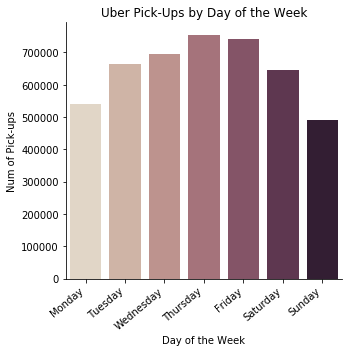

In [25]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
ax = (sns
      .catplot(x="weekday", 
               y = 'cnt',
               kind="bar", 
               palette="ch:.25", 
               data=cnts))

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by Day of the Week',
       xlabel='Day of the Week', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()

## <font color="red"> Exercise 2 </font>

Compute and visualize the hourly frequencies for Uber pick-ups across all of the files.

In [49]:
# Your code here

## Up Next

Stuff